In [66]:
import sys, os
import glob
import numpy
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt
from iris.experimental.equalise_cubes import equalise_attributes

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv

In [72]:
hist_files = glob.glob('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r*i1p1/hfbasin/latest/hfbasin-global_Oyr_CSIRO-Mk3-6-0_historical_r*i1p1_all.nc')
ghg_files = glob.glob('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalGHG/yr/ocean/r*i1p1/hfbasin/latest/hfbasin-global_Oyr_CSIRO-Mk3-6-0_historicalGHG_r*i1p1_all.nc')
aa_files = glob.glob('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalMisc/yr/ocean/r*i1p4/hfbasin/latest/hfbasin-global_Oyr_CSIRO-Mk3-6-0_historicalMisc_r*i1p4_all.nc')

In [83]:
def sum_sign(data, sign_to_keep):
    """Sum all positive or negative values and return absolute value.
    
    Args:
      data (numpy.ndarray)
      sign_to_keep (str)
      
    """
    
    data = data.copy()
    data = numpy.ma.asarray(data)
    
    assert sign_to_keep in ['positive', 'negative']
    if sign_to_keep == 'positive':
        mask = data < 0
    else:
        mask = data > 0
        
    data.mask = mask
    
    return numpy.abs(data.sum(axis=1))


def calc_metric(filename, filenum):
    """Calculate the hfbasin metric for a given input file."""

    cube = iris.load_cube(filename, 'northward_ocean_heat_transport')
    
    coord_names = [coord.name() for coord in cube.dim_coords]
    assert coord_names == ['time', 'latitude']
    
    lat_spacing = cube.coord('latitude').bounds[:, 1] - cube.coord('latitude').bounds[:, 0]
    area_data = cube.data * uconv.broadcast_array(lat_spacing, 1, cube.shape)
    
    metric_data = sum_sign(area_data, 'positive') - sum_sign(area_data, 'negative')
    
    metric_cube = cube.extract(iris.Constraint(latitude=0))
    metric_cube.remove_coord('latitude')
    metric_cube.data = metric_data
    
    ensemble_aux_coord = iris.coords.AuxCoord(filenum, long_name='ensemble_member', units='no_unit')
    metric_cube.add_aux_coord(ensemble_aux_coord)
    
    return metric_cube


def equalise_time_axes(cube_list):
    """Make all the time axes the same."""

    iris.util.unify_time_units(cube_list)
    reference_cube = cube_list[0]
    new_cube_list = iris.cube.CubeList([])
    for cube in cube_list:
        assert len(cube.coord('time').points) == len(reference_cube.coord('time').points)
        cube.coord('time').points = reference_cube.coord('time').points
        cube.coord('time').bounds = reference_cube.coord('time').bounds
        cube.coord('time').units = reference_cube.coord('time').units
        cube.coord('time').attributes = reference_cube.coord('time').attributes
        new_cube_list.append(cube)
    
    return new_cube_list


def ensemble_mean_metric(file_list):
    """Calculate the ensemble mean metric."""
    
    cube_list = iris.cube.CubeList([])
    for filenum, infile in enumerate(file_list):
        metric_cube = calc_metric(infile, filenum)
        cube_list.append(metric_cube)
    
    equalise_attributes(cube_list)
    cube_list = equalise_time_axes(cube_list)
    ensemble_cube = cube_list.merge_cube()
    ensemble_mean = ensemble_cube.collapsed('ensemble_member', iris.analysis.MEAN)
    
    return ensemble_mean

In [84]:
hist_metric = ensemble_mean_metric(hist_files)
ghg_metric = ensemble_mean_metric(ghg_files)
aa_metric = ensemble_mean_metric(aa_files)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))


In [85]:
%matplotlib inline

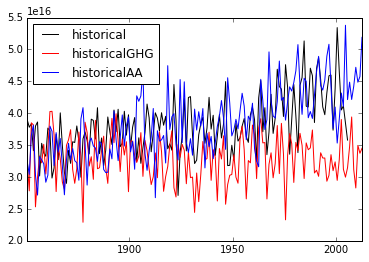

In [86]:
iplt.plot(hist_metric, color='black', label='historical')
iplt.plot(ghg_metric, color='red', label='historicalGHG')
iplt.plot(aa_metric, color='blue', label='historicalAA')
plt.legend(loc=2)
plt.show()

TODO: Do the same plot for northward ocean heat transport at the equator to show that you need to use information from the whole hfbasin distribution in order to get good separation between the historicalGHG and historicalAA data.